# PCA on artificial data: Lecture 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.vq import vq, kmeans, whiten

# seed the pseudo random number generator with 0 
# so that the results are consistent in all discussion sections
np.random.seed(0)

# Matplotlib produces annoying warnings (see https://github.com/matplotlib/matplotlib/issues/5209)
# ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In this example we'll generate two clusters of data points on a plane, combine them into a single dataset, randomly embed it in a higher dimensional space, add quite a lot of noise, and then try to use PCA to separate the data into the two original clusters.

## Generating 2D data

For each cluster we'll draw random points drawn from a Gaussian distribution centered around its mean, with a predefined standard deviation.

[You will learn more about probability, the gaussian distribution, mean and standard deviation in CS70. For now it is enough to know that the points of each clustered are centered around the mean and at least 95% are within twice the standard deviation from the mean.]

In [2]:
def cluster(mean, stddev, size):
    return np.random.multivariate_normal(mean, np.eye(mean.shape[0])*stddev**2, size).T

We'll create four clusters of 500 points each, centered around (5,5) and (-5, -5) and (0,10) with standard deviation of 1.

In [3]:
N = 500

#mean1 = np.array([5, 3])
#mean2 = np.array([-7, -5])
#mean3 = np.array([-5, 2])
#mean4 = np.array([1,-4])
mean1 = np.array([5, 5])
mean2 = np.array([-5, -5])
mean3 = np.array([-5, 5])
mean4 = np.array([5,-5])
stddev = 1

cluster1 = cluster(mean1, stddev, N)
cluster2 = cluster(mean2, stddev, N)
cluster3 = cluster(mean3, stddev, N)
cluster4 = cluster(mean4, stddev, N)

We'll combine all clusters into a single dataset and shuffle it for good measure

In [4]:
dataset_2d = np.c_[cluster1, cluster2, cluster3, cluster4]
np.random.shuffle(dataset_2d)

In [5]:
dataset_2d

array([[ 5.40015721,  7.2408932 ,  4.02272212, ..., -5.50388989,
        -5.03057244, -5.8128021 ],
       [ 6.76405235,  5.97873798,  6.86755799, ...,  5.39494819,
         6.77955908,  6.57708821]])

The dataset looks pretty much like we expected.

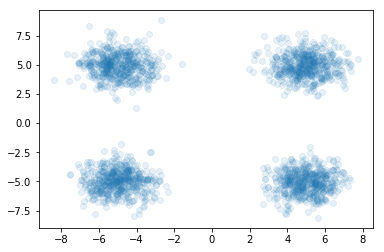

In [6]:
plt.scatter(*dataset_2d, alpha=0.1)
plt.show()

## Embedding the 2D data into a 25D space

We have a 2D dataset, we'll embed it into a 25 dimensional space by multiplying it with a random 25x2 matrix.

To understand how this works, we'll first embed it in a three dimensional space in two ways.

In [7]:
def embed_and_plot(M):
    
    dataset_3d = M.dot(dataset_2d)

    ax = plt.subplot(projection='3d')
    ax.scatter(*dataset_3d, alpha=0.1)

First, embed the our points in the X-Y plane:

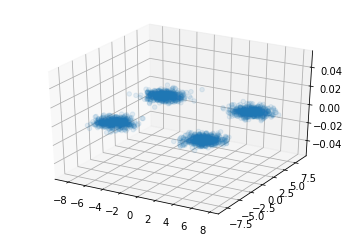

In [8]:
embed_and_plot(np.array([[1, 0],[0, 1], [0, 0]]))

Next, embed it as a different plane. From our point of view, it is now harder to separate the clusters.

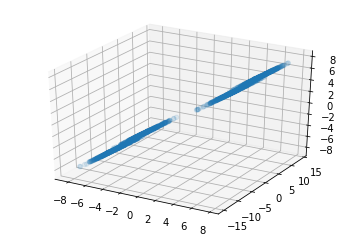

In [9]:
embed_and_plot(np.array([[1, 0],[1, -1], [1, 0]]))

Now return to our 25-dimensional space. We'll generate a random 25x2 matrix and multiply the matrix by each point.

[Note that this matrix has to be of rank 2, otherwise the data will become one dimensional - but the probability of a random 25x2 matrix to be of rank less than 2 is negligible]

In [10]:
D = 25
M = np.random.rand(D, 2)
print("The rank of M is", np.linalg.matrix_rank(M))

dataset_Dd = M.dot(dataset_2d)

The rank of M is 2


How does this data look like? Let's pick two random axes and view the data projected over these axis.

In [11]:
axes = np.random.randint(0, D, 2)

In [12]:
axes

array([20, 12])

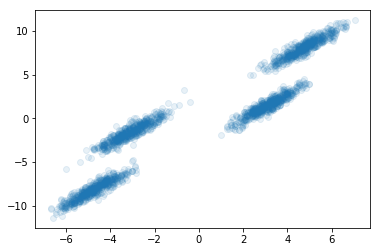

In [13]:
plt.scatter(dataset_Dd[axes[0]], dataset_Dd[axes[1]], alpha=0.1)
plt.show()

Not too bad, even though we picked random axes, the clusters are clearly distinguishable.

## Adding some noise

But what happens if we add random noise? let's add quite a lot of noise:

In [14]:
noise_stddev = 5
noise = np.random.multivariate_normal(np.zeros(D), np.eye(D)*noise_stddev**2, dataset_Dd.shape[1]).T

noisy_dataset = dataset_Dd + noise

Let's draw it again over the same axes:

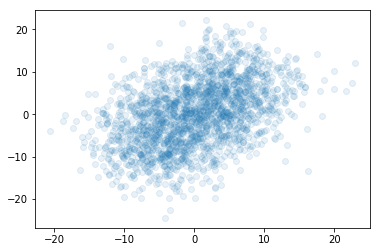

In [15]:
plt.scatter(noisy_dataset[axes[0]], noisy_dataset[axes[1]], alpha=0.1)
plt.show()

The separate clusters are pretty much gone now, as the clusters are overshadowed by the noise.

## PCA

Can we use PCA to recover the clusters from the noise?

In PCA, we perform SVD and project over the columns of U that correspond to the singular values with the highest magnitude. These vectors are called the **principal components**.

In [16]:
U, S, Vt = np.linalg.svd(noisy_dataset.T)

In this case, we'll pick the first two principal components. Why two? we started with two dimensional data, so it makes sense to pick two principal components. We'll revisit this decision later.

In [17]:
PC = Vt.T[::,:2]

In [18]:
PC

array([[-0.22319463,  0.20562393],
       [-0.13608718,  0.2125757 ],
       [-0.2864234 ,  0.03172776],
       [-0.16524457, -0.16279052],
       [-0.17645201,  0.18754551],
       [-0.29001766,  0.02234059],
       [-0.21143687, -0.10076984],
       [-0.30245918,  0.01389629],
       [-0.2343862 ,  0.23015472],
       [-0.16809925, -0.12431053],
       [-0.21253381, -0.22645792],
       [-0.18938012,  0.21203984],
       [-0.26118411, -0.12058781],
       [-0.18011733,  0.22916835],
       [-0.16045106, -0.3594636 ],
       [-0.13647443,  0.14203625],
       [-0.15788609,  0.11681608],
       [-0.14953455, -0.32921663],
       [-0.20071877, -0.03621849],
       [-0.25834198, -0.06901349],
       [-0.15491399, -0.29385544],
       [-0.16626447,  0.34353028],
       [-0.08733157,  0.10986641],
       [-0.13992965, -0.33506743],
       [-0.16870746,  0.03282469]])

We'll project the data into the first two principal components:

In [19]:
projected_cleandataset = PC.T.dot(dataset_Dd)
projected_noisydataset = PC.T.dot(noisy_dataset)

Then plot the result:

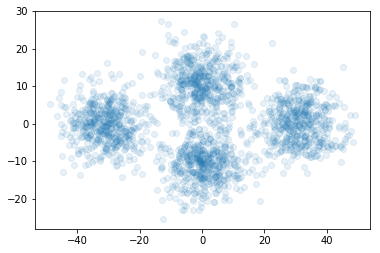

In [20]:
plt.scatter(*projected_noisydataset, alpha=0.1)
plt.show()

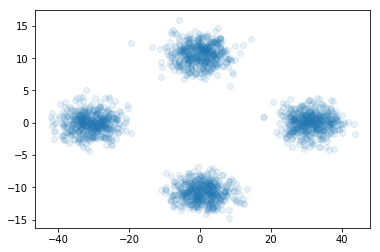

In [21]:
plt.scatter(*projected_cleandataset, alpha=0.1)
plt.show()

Even though we added a lot of noise, we still get distinguishable clusters, but they are blurring together on the boundaries. That's from the noise. Notice that we have gone from a square to a diamond shape. 

In [23]:
NextPC = Vt.T[::,2:4]
nextnoisyprojections = NextPC.T.dot(noisy_dataset)
nextcleanprojections = NextPC.T.dot(dataset_Dd)

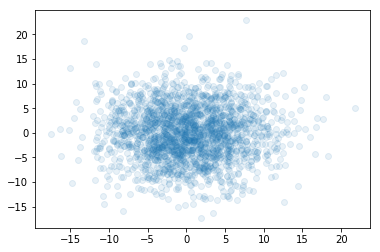

In [24]:
plt.scatter(*nextnoisyprojections, alpha=0.1)
plt.show()

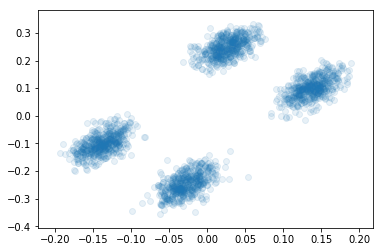

In [25]:
plt.scatter(*nextcleanprojections, alpha=0.1)
plt.show()

Notice that even in the next pair of dimensions, there is no visible trace of the signal in noise, and very little (look at the scales) signal present even without noise. 

## Principal components:

Let us go back to the signular values and plot them:

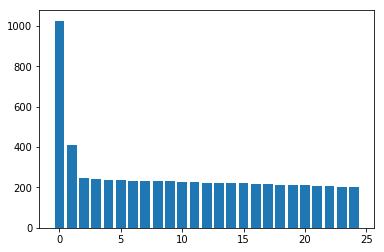

In [26]:
plt.bar(np.arange(S.shape[0]), S)
plt.show()